In [1]:
%matplotlib inline

In [2]:
from time import time
import logging
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
import seaborn as sns
import numpy as np


In [3]:
print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


Automatically created module for IPython interactive environment


In [4]:
lfw_people = fetch_lfw_people(min_faces_per_person=60)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


2021-04-29 06:49:27,244 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976012
2021-04-29 06:49:28,627 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976009
2021-04-29 06:49:29,984 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976006
2021-04-29 06:49:31,624 Downloading LFW data (~200MB): https://ndownloader.figshare.com/files/5976015


Total dataset size:
n_samples: 1348
n_features: 2914
n_classes: 8


In [5]:
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


In [6]:
##########################################################
# PCA
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True)

Extracting the top 150 eigenfaces from 1011 faces


In [7]:
##########################################################
# SVC and GridSearchCV
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
svc = SVC(kernel='rbf', class_weight='balanced')
clf = GridSearchCV(svc, param_grid)
print("done in %0.3fs" % (time() - t0))


Fitting the classifier to the training set
done in 0.000s


In [8]:
model = make_pipeline(pca, clf)

In [9]:
t0 = time()
model = model.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))

done in 53.001s


In [10]:
clf.best_estimator_

SVC(C=1000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.001,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [11]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = model.predict(X_test)
print("done in %0.3fs" % (time() - t0))


Predicting people's names on the test set
done in 0.093s


                   precision    recall  f1-score   support

     Ariel Sharon       0.69      0.73      0.71        15
     Colin Powell       0.81      0.82      0.82        68
  Donald Rumsfeld       0.77      0.77      0.77        31
    George W Bush       0.84      0.83      0.84       126
Gerhard Schroeder       0.77      0.74      0.76        23
      Hugo Chavez       0.87      0.65      0.74        20
Junichiro Koizumi       0.85      0.92      0.88        12
       Tony Blair       0.80      0.88      0.84        42

         accuracy                           0.81       337
        macro avg       0.80      0.79      0.79       337
     weighted avg       0.81      0.81      0.81       337



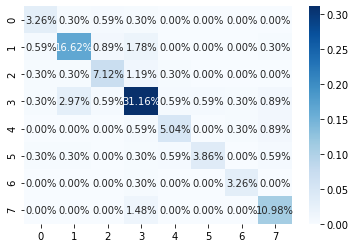

In [12]:

print(classification_report(y_test, y_pred, target_names=target_names))
# print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat/np.sum(conf_mat), fmt='.2%', cmap='Blues', annot=True)

Wrong prediction: Blair
True:      Bush
Wrong prediction: Bush
True:      Powell
Wrong prediction: Rumsfeld
True:      Bush
Wrong prediction: Bush
True:      Blair
Wrong prediction: Powell
True:      Bush
Wrong prediction: Blair
True:      Bush


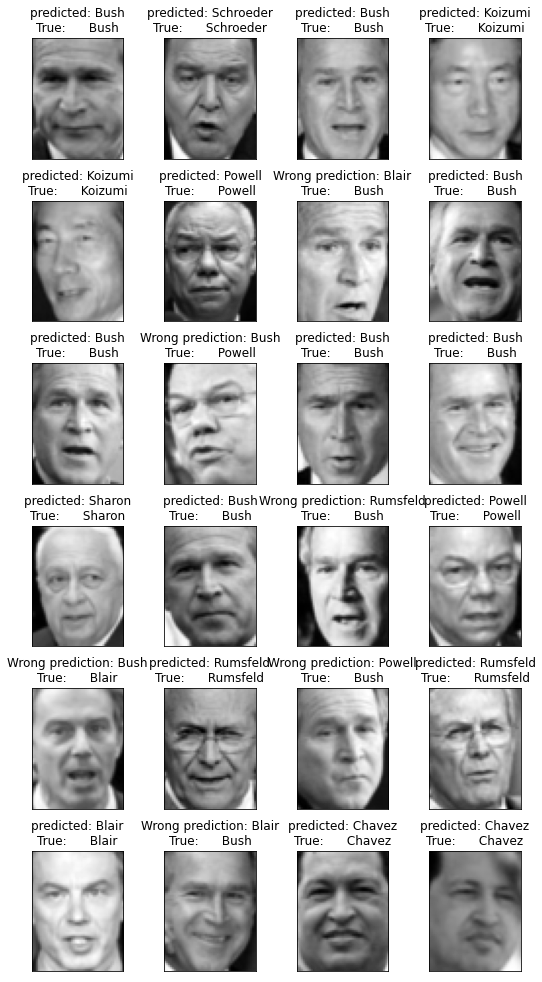

In [13]:
# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=6, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        x = titles[i].split('\n')
        y = x[0].split(':')
        # print(y)
        if y[0] != 'predicted':
          plt.xticks.color = 'Red'
          plt.yticks.color = 'Red'
          plt.axes.labelcolor = 'red'
          # plt.xaxis.label.set_color('red')
          plt.tick_params(axis='x', colors='red')
          print(titles[i])
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    # print("\x1b[31m\aabc\x1b[0m")
    if pred_name == true_name : 
      return 'predicted: %s\nTrue:      %s' % (pred_name, true_name)
    else:
      return 'Wrong prediction: %s\nTrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)